Here we'll first be loading the FC matrices and explore their structure

In [3]:
#dataset MUTAG
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Entities
from torch_geometric.transforms import TargetIndegree

# Load the AIFB dataset
dataset = Entities(root='/tmp/AIFB', name='AIFB')
dataset[0]

Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)

In [4]:
dataset.data

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)

In [5]:
data = dataset[0]  # AIFB is a single graph

# Create one-hot encoded node features for the entire dataset
num_nodes = data.num_nodes
data.x = torch.eye(num_nodes)  # One-hot encoding for all nodes


In [6]:
dataset.data = data  # This line ensures the dataset now references the modified data


In [7]:
#set the seed
torch.manual_seed(37)

MODEL = "GCN"
DATASET = "AIFB"

from models.models_MUTAG import GCN_framework as framework # import the model

gnn = framework(dataset)


In [8]:
# gnn.iterate()

In [9]:
# gnn.train()

In [10]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [11]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [12]:
gnn.evaluate()

Final Evaluation - Train Acc: 1.000, Test Acc: 0.889


In [13]:
train_features, test_features = gnn.evaluate_with_features2()

Features generated from model, shape of output: [torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 4])]
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 4]), train_indices max: 8240


In [17]:
print(len(train_features[0]))
print(len(test_features[0]))
len(train_features), len(test_features)

140
36


(5, 5)

In [19]:
train_features[0][0].shape

(128,)

In [19]:
#we have the train_idx=[140], test_idx=[36]

#we want to calculate the node properties of the train and test nodes such as node degree, clustering coefficient, betweenness centrality, closeness centrality, eigenvector centrality, and pagerank. And get the train_node_properties and test_node_properties

#we will use the networkx library to calculate the node properties
# Convert PyTorch Geometric Data to NetworkX format
import networkx as nx
from torch_geometric.utils import to_networkx
import torch

G = to_networkx(data, to_undirected=True)

# Calculate various node properties using NetworkX
degree = dict(G.degree())
clustering = nx.clustering(G)
# betweenness = nx.betweenness_centrality(G)
# closeness = nx.closeness_centrality(G)
# eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
# pagerank = nx.pagerank(G)


In [20]:

# Create a function to gather properties for specific nodes
def get_node_properties(indices):
    properties = []
    for idx in indices:
        properties.append({
            'degree': degree[idx],
            'clustering': clustering[idx],
            # 'betweenness': betweenness[idx],
            # 'closeness': closeness[idx],
            # 'eigenvector': eigenvector[idx],
            # 'pagerank': pagerank[idx]
        })
    return properties

# Extract node properties for train and test indices
train_node_properties = get_node_properties(data.train_idx.tolist())
test_node_properties = get_node_properties(data.test_idx.tolist())

# Convert to tensor format if needed
train_node_properties_tensor = {key: torch.tensor([prop[key] for prop in train_node_properties]) for key in train_node_properties[0]}
test_node_properties_tensor = {key: torch.tensor([prop[key] for prop in test_node_properties]) for key in test_node_properties[0]}



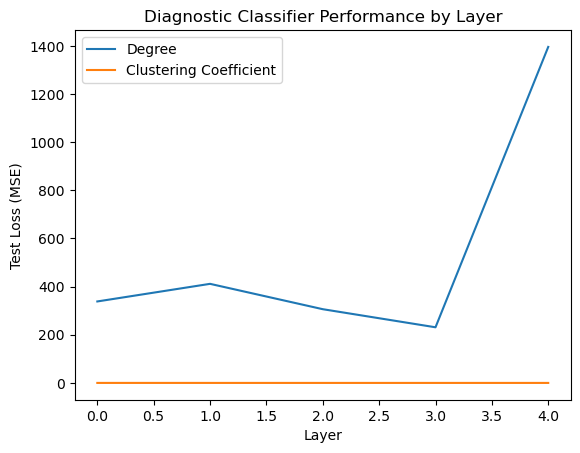

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming train_features, test_features, train_node_properties_tensor, and test_node_properties_tensor are available

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

def train_linear_model(train_x, train_y, test_x, test_y, num_epochs=1000, learning_rate=0.01):
    input_size = train_x.shape[1]
    output_size = train_y.shape[1]

    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()  # For regression tasks
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_x)
        test_loss = criterion(test_outputs, test_y).item()

    return model, test_loss

# Function to evaluate and plot results for each layer and property
def evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor):
    num_layers = len(train_features)
    num_properties = train_node_properties_tensor.shape[1]

    test_losses = torch.zeros((num_layers, num_properties))

    for layer_idx in range(num_layers):
        for prop_idx in range(num_properties):
            train_x = torch.tensor(train_features[layer_idx])
            test_x = torch.tensor(test_features[layer_idx])
            train_y = train_node_properties_tensor[:, prop_idx].unsqueeze(1)
            test_y = test_node_properties_tensor[:, prop_idx].unsqueeze(1)

            _, test_loss = train_linear_model(train_x, train_y, test_x, test_y)
            test_losses[layer_idx, prop_idx] = test_loss

    # Plotting the results
    property_names = ['Degree', 'Clustering Coefficient']  # Adjust according to your properties
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), test_losses[:, prop_idx].numpy(), label=f"{property_names[prop_idx]}")

    plt.xlabel("Layer")
    plt.ylabel("Test Loss (MSE)")
    plt.title("Diagnostic Classifier Performance by Layer")
    plt.legend()
    plt.show()

# Now evaluate and plot the results
evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)


In [52]:
train_features[0][139]

array([ 1.3555768 , -0.2241855 , -0.18257284, -0.2737489 ,  1.3292845 ,
       -1.0234201 ,  1.5573556 ,  1.2646968 , -0.21248208, -0.5439213 ,
        0.14268374, -1.0055735 , -0.19394766, -0.5898287 ,  3.42712   ,
       -0.52868223, -0.756886  , -0.39360148, -0.70778924, -0.9648495 ,
       -0.39419457, -0.58542466,  1.9438896 ,  1.2779977 ,  3.3278584 ,
       -0.4534662 , -0.7998004 , -0.31150052,  1.2959744 , -0.5668221 ,
        0.9298318 ,  1.8480177 , -0.79953223, -1.0220441 ,  1.4006733 ,
       -0.24722424, -0.5150197 , -0.771422  , -0.30894232, -0.1736691 ,
        1.2043242 , -0.6904449 , -0.80797184, -0.26802537, -0.94709486,
       -0.60023254, -0.38798   , -0.9344617 ,  0.09242868, -0.5018424 ,
        0.69517636, -0.9876125 ,  0.98329353, -1.0271348 , -0.545658  ,
        0.42941514,  0.04523568, -0.61728716, -0.6893512 , -0.96952766,
       -0.2916307 , -0.04117952,  1.0595467 , -1.1335886 , -1.3392901 ,
        1.7542977 ,  0.18756652, -0.4467741 , -0.41738206, -0.36

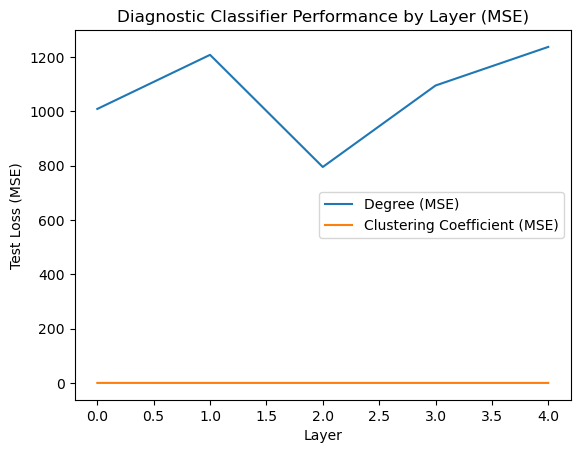

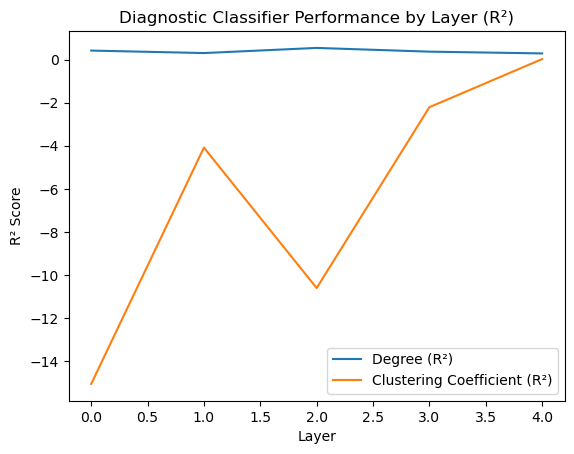

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

def train_linear_model(train_x, train_y, test_x, test_y, num_epochs=10000, learning_rate=0.01):
    input_size = train_x.shape[1]
    output_size = train_y.shape[1]

    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_x)
        test_loss = criterion(test_outputs, test_y).item()
        r2 = r2_score(test_y.cpu().numpy(), test_outputs.cpu().numpy())

    return model, test_loss, r2

def evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor):
    num_layers = len(train_features)
    num_properties = train_node_properties_tensor.shape[1]

    test_losses = torch.zeros((num_layers, num_properties))
    r2_scores = torch.zeros((num_layers, num_properties))

    for layer_idx in range(num_layers):
        for prop_idx in range(num_properties):
            train_x = torch.tensor(train_features[layer_idx])
            test_x = torch.tensor(test_features[layer_idx])
            train_y = train_node_properties_tensor[:, prop_idx].unsqueeze(1)
            test_y = test_node_properties_tensor[:, prop_idx].unsqueeze(1)

            _, test_loss, r2 = train_linear_model(train_x, train_y, test_x, test_y)
            test_losses[layer_idx, prop_idx] = test_loss
            r2_scores[layer_idx, prop_idx] = r2

    # Plotting the results for MSE loss
    property_names = ['Degree', 'Clustering Coefficient']  # Adjust according to your properties
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), test_losses[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (MSE)")

    plt.xlabel("Layer")
    plt.ylabel("Test Loss (MSE)")
    plt.title("Diagnostic Classifier Performance by Layer (MSE)")
    plt.legend()
    plt.show()

    # Plotting the results for R² score
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), r2_scores[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (R²)")

    plt.xlabel("Layer")
    plt.ylabel("R² Score")
    plt.title("Diagnostic Classifier Performance by Layer (R²)")
    plt.legend()
    plt.show()

# Now evaluate and plot the results
evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

def train_linear_model_single_node(train_x, train_y, test_x, test_y, num_epochs=100, learning_rate=0.01):
    input_size = train_x.shape[0]  # The size of the vector representation of a single node
    output_size = 1  # Since we're predicting a scalar property

    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Add a batch dimension to the inputs
    train_x = train_x.unsqueeze(0)  # Shape becomes (1, input_size)
    train_y = torch.tensor([[train_y]])  # Shape becomes (1, 1)
    test_x = test_x.unsqueeze(0)  # Shape becomes (1, input_size)
    test_y = torch.tensor([[test_y]])  # Shape becomes (1, 1)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_x)
        test_loss = criterion(test_outputs, test_y).item()
        r2 = r2_score(test_y.cpu().numpy(), test_outputs.cpu().numpy())

    return model, test_loss, r2

def evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor):
    num_layers = len(train_features)
    num_properties = train_node_properties_tensor.shape[1]

    test_losses = torch.zeros((num_layers, num_properties))
    r2_scores = torch.zeros((num_layers, num_properties))

    for layer_idx in range(num_layers):
        for prop_idx in range(num_properties):
            layer_train_features = train_features[layer_idx]  # Shape: (140, 128)
            layer_test_features = test_features[layer_idx]    # Shape: (36, 128)

            train_y = train_node_properties_tensor[:, prop_idx]  # Shape: (140,)
            test_y = test_node_properties_tensor[:, prop_idx]    # Shape: (36,)

            # Initialize lists to collect losses and R² scores for each node
            losses = []
            r2_scores_per_node = []

            # Train and evaluate on each node individually
            for node_idx in range(layer_train_features.shape[0]):
                train_x = torch.tensor(layer_train_features[node_idx])  # Shape: (128,)
                train_property = train_y[node_idx].item()  # Convert to scalar

                test_x = torch.tensor(layer_test_features[node_idx])  # Shape: (128,)
                test_property = test_y[node_idx].item()  # Convert to scalar

                _, test_loss, r2 = train_linear_model_single_node(train_x, train_property, test_x, test_property)
                losses.append(test_loss)
                r2_scores_per_node.append(r2)

            # Average loss and R² scores over all nodes for this property and layer
            test_losses[layer_idx, prop_idx] = torch.tensor(losses).mean()
            r2_scores[layer_idx, prop_idx] = torch.tensor(r2_scores_per_node).mean()

    # Plotting the results for MSE loss
    property_names = ['Degree', 'Clustering Coefficient']  # Adjust according to your properties
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), test_losses[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (MSE)")

    plt.xlabel("Layer")
    plt.ylabel("Test Loss (MSE)")
    plt.title("Diagnostic Classifier Performance by Layer (MSE)")
    plt.legend()
    plt.show()

    # Plotting the results for R² score
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), r2_scores[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (R²)")

    plt.xlabel("Layer")
    plt.ylabel("R² Score")
    plt.title("Diagnostic Classifier Performance by Layer (R²)")
    plt.legend()
    plt.show()

# Now evaluate and plot the results
evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Unexpected exception formatting exception. Falling back to standard exception


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\2105161642.py", line 102, in <module>
    evaluate_layers(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\2105161642.py", line 69, in evaluate_layers
    test_x = torch.tensor(layer_test_features[node_idx])  # Shape: (128,)
Index

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

def train_probe_for_node(features, property_value, num_epochs=100, learning_rate=0.01):
    model = LinearModel(features.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    features = features.unsqueeze(0)  # Add batch dimension if it's not there
    property_value = torch.tensor([property_value], dtype=torch.float32).unsqueeze(0)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, property_value)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(features)
        mse = criterion(pred, property_value).item()
        r2 = r2_score(property_value.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

def evaluate_node_probes(train_features, test_features, train_properties, test_properties):
    num_layers = len(train_features)
    results = []

    for layer_idx in range(num_layers):
        layer_train_features = train_features[layer_idx]
        layer_test_features = test_features[layer_idx]
        
        # Iterate over each node for training
        mse_scores, r2_scores = [], []
        for node_idx, node_features in enumerate(layer_train_features):
            node_property = train_properties[node_idx]
            mse, r2 = train_probe_for_node(node_features, node_property['degree'])  # Example for 'degree'
            mse_scores.append(mse)
            r2_scores.append(r2)
        
        results.append({
            'layer': layer_idx,
            'mse_scores': mse_scores,
            'r2_scores': r2_scores
        })
    
    # Plotting the results
    for result in results:
        layer = result['layer']
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(result['mse_scores'], bins=30)
        plt.title(f'Layer {layer} - MSE Distribution')
        plt.xlabel('MSE Score')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.hist(result['r2_scores'], bins=30)
        plt.title(f'Layer {layer} - R² Score Distribution')
        plt.xlabel('R² Score')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()


evaluate_node_probes(train_features, test_features, train_node_properties, test_node_properties)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\1821916416.py", line 81, in <module>
    evaluate_node_probes(train_features, test_features, train_node_properties, test_node_properties)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\1821916416.py", line 51, in evaluate_node_probes
    mse, r2 = train_probe_for_node(node_features, node_property['degree'])  # Example for 'degree'
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_16156\1821916416.py", line 16, in train_probe_for_node
    model = LinearModel(features.shape[1])
IndexError: tuple index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtr

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32
Training on features with shape: torch.Size([1, 128]) for property value: 125
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7
Training on features with shape: torch.Size([1, 128]) for property value: 31
Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 27
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 67
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 38
Training on features with shape: torch.Size([1, 128]) for property value: 26
Training on features with shape: torch.Size([1, 128]) for property value: 21
Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 51
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 35
Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 83
Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 252
Training on features with shape: torch.Size([1, 128]) for property value: 10
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 34
Training on features with shape: torch.Size([1, 128]) for property value: 12
Training on features with shape: torch.Size([1, 128]) for property value: 7
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 95
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95
Training on features with shape: torch.Size([1, 128]) for property value: 64
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52
Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 60
Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 79
Training on features with shape: torch.Size([1, 128]) for property value: 22
Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 51
Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33
Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43
Training on features with shape: torch.Size([1, 128]) for property value: 30
Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 18
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 12
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 32
Training on features with shape: torch.Size([1, 128]) for property value: 125
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 26
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 7
Training on features with shape: torch.Size([1, 128]) for property value: 31
Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 27
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 67
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 38
Training on features with shape: torch.Size([1, 128]) for property value: 26
Training on features with shape: torch.Size([1, 128]) for property value: 21
Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 51
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 35
Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 83
Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 252
Training on features with shape: torch.Size([1, 128]) for property value: 10
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34
Training on features with shape: torch.Size([1, 128]) for property value: 12
Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 95
Training on features with shape: torch.Size([1, 128]) for property value: 64
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 52
Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 60
Training on features with shape: torch.Size([1, 128]) for property value: 27
Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 79
Training on features with shape: torch.Size([1, 128]) for property value: 22
Training on features with shape: torch.Size([1, 128]) for property value: 85
Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51
Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 33
Training on features with shape: torch.Size([1, 128]) for property value: 66
Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 30
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 202
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 27
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 10
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 12
Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 31
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 32
Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 26
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 31
Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 27
Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 38
Training on features with shape: torch.Size([1, 128]) for property value: 26
Training on features with shape: torch.Size([1, 128]) for property value: 21
Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 51
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 35
Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 83
Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 252
Training on features with shape: torch.Size([1, 128]) for property value: 10
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 34
Training on features with shape: torch.Size([1, 128]) for property value: 12
Training on features with shape: torch.Size([1, 128]) for property value: 7
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 95
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 95
Training on features with shape: torch.Size([1, 128]) for property value: 64
Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 52
Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 60
Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 79
Training on features with shape: torch.Size([1, 128]) for property value: 22
Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 51
Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 33
Training on features with shape: torch.Size([1, 128]) for property value: 66
Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 30
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 202
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 27
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 18
Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 10
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 31
Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 12
Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 32
Training on features with shape: torch.Size([1, 128]) for property value: 125
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 26
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 7
Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 27
Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 67
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 38
Training on features with shape: torch.Size([1, 128]) for property value: 26
Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 51
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 25
Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 78
Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 10
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 34
Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 7
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 11
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 95
Training on features with shape: torch.Size([1, 128]) for property value: 64
Training on features with shape: torch.Size([1, 128]) for property value: 8
Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19
Training on features with shape: torch.Size([1, 128]) for property value: 60
Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 128]) for property value: 79
Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85
Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 51
Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 15
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 41
Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 66
Training on features with shape: torch.Size([1, 128]) for property value: 43
Training on features with shape: torch.Size([1, 128]) for property value: 30
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 16
Training on features with shape: torch.Size([1, 128]) for property value: 23
Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3
Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 14
Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 18
Training on features with shape: torch.Size([1, 128]) for property value: 5
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 17
Training on features with shape: torch.Size([1, 128]) for property value: 9
Training on features with shape: torch.Size([1, 128]) for property value: 12
Training on features with shape: torch.Size([1, 128]) for property value: 36
Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 6
Training on features with shape: torch.Size([1, 128]) for property value: 4
Training on features with shape: torch.Size([1, 128]) for property value: 29
Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 128]) for property value: 13
Training on features with shape: torch.Size([1, 128]) for property value: 31
Training on features with shape: torch.Size([1, 128]) for property value: 20
Training on features with shape: torch.Size([1, 4]) for property value: 3
Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 17
Training on features with shape: torch.Size([1, 4]) for property value: 20
Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 12
Training on features with shape: torch.Size([1, 4]) for property value: 23
Training on features with shape: torch.Size([1, 4]) for property value: 29
Training on features with shape: torch.Size([1, 4]) for property value: 6
Training on features with shape: torch.Size([1, 4]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 125
Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 26
Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 19
Training on features with shape: torch.Size([1, 4]) for property value: 36
Training on features with shape: torch.Size([1, 4]) for property value: 15
Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 13
Training on features with shape: torch.Size([1, 4]) for property value: 7
Training on features with shape: torch.Size([1, 4]) for property value: 31
Training on features with shape: torch.Size([1, 4]) for property value: 41
Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 27
Training on features with shape: torch.Size([1, 4]) for property value: 15
Training on features with shape: torch.Size([1, 4]) for property value: 13
Training on features with shape: torch.Size([1, 4]) for property value: 20
Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 67
Training on features with shape: torch.Size([1, 4]) for property value: 17
Training on features with shape: torch.Size([1, 4]) for property value: 36
Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 8
Training on features with shape: torch.Size([1, 4]) for property value: 8
Training on features with shape: torch.Size([1, 4]) for property value: 23
Training on features with shape: torch.Size([1, 4]) for property value: 6
Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 16
Training on features with shape: torch.Size([1, 4]) for property value: 3
Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 3
Training on features with shape: torch.Size([1, 4]) for property value: 38
Training on features with shape: torch.Size([1, 4]) for property value: 26
Training on features with shape: torch.Size([1, 4]) for property value: 21
Training on features with shape: torch.Size([1, 4]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 51
Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 35
Training on features with shape: torch.Size([1, 4]) for property value: 78
Training on features with shape: torch.Size([1, 4]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 9
Training on features with shape: torch.Size([1, 4]) for property value: 83
Training on features with shape: torch.Size([1, 4]) for property value: 11
Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 78
Training on features with shape: torch.Size([1, 4]) for property value: 15
Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 3
Training on features with shape: torch.Size([1, 4]) for property value: 8
Training on features with shape: torch.Size([1, 4]) for property value: 252
Training on features with shape: torch.Size([1, 4]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 17
Training on features with shape: torch.Size([1, 4]) for property value: 34
Training on features with shape: torch.Size([1, 4]) for property value: 12
Training on features with shape: torch.Size([1, 4]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 3
Training on features with shape: torch.Size([1, 4]) for property value: 11
Training on features with shape: torch.Size([1, 4]) for property value: 14
Training on features with shape: torch.Size([1, 4]) for property value: 95
Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 16
Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 17
Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 64
Training on features with shape: torch.Size([1, 4]) for property value: 8
Training on features with shape: torch.Size([1, 4]) for property value: 17
Training on features with shape: torch.Size([1, 4]) for property value: 52
Training on features with shape: torch.Size([1, 4]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 60
Training on features with shape: torch.Size([1, 4]) for property value: 27
Training on features with shape: torch.Size([1, 4]) for property value: 16
Training on features with shape: torch.Size([1, 4]) for property value: 3
Training on features with shape: torch.Size([1, 4]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 79
Training on features with shape: torch.Size([1, 4]) for property value: 22
Training on features with shape: torch.Size([1, 4]) for property value: 85
Training on features with shape: torch.Size([1, 4]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 51
Training on features with shape: torch.Size([1, 4]) for property value: 29
Training on features with shape: torch.Size([1, 4]) for property value: 15
Training on features with shape: torch.Size([1, 4]) for property value: 16
Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 41
Training on features with shape: torch.Size([1, 4]) for property value: 33
Training on features with shape: torch.Size([1, 4]) for property value: 66
Training on features with shape: torch.Size([1, 4]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 30
Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 202
Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16
Training on features with shape: torch.Size([1, 4]) for property value: 23
Training on features with shape: torch.Size([1, 4]) for property value: 3
Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 3
Training on features with shape: torch.Size([1, 4]) for property value: 6
Training on features with shape: torch.Size([1, 4]) for property value: 14
Training on features with shape: torch.Size([1, 4]) for property value: 27
Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

Training on features with shape: torch.Size([1, 4]) for property value: 18
Training on features with shape: torch.Size([1, 4]) for property value: 5
Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 10
Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 9
Training on features with shape: torch.Size([1, 4]) for property value: 12
Training on features with shape: torch.Size([1, 4]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13
Training on features with shape: torch.Size([1, 4]) for property value: 6
Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4
Training on features with shape: torch.Size([1, 4]) for property value: 29
Training on features with shape: torch.Size([1, 4]) for property value: 78
Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 31
Training on features with shape: torch.Size([1, 4]) for property value: 20


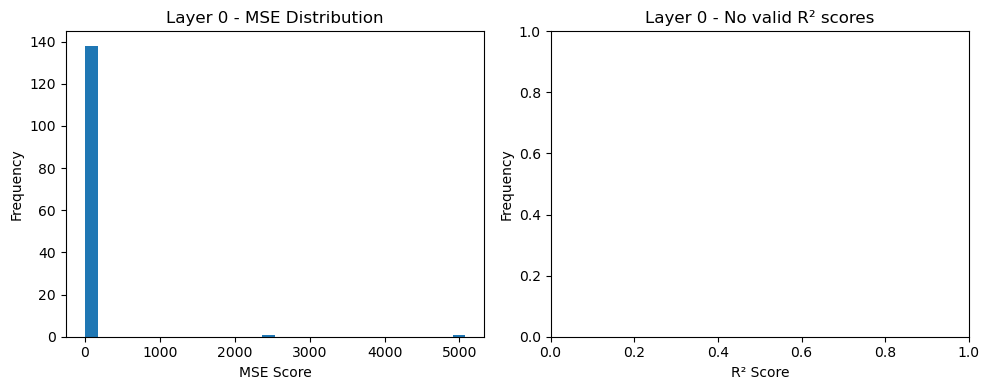

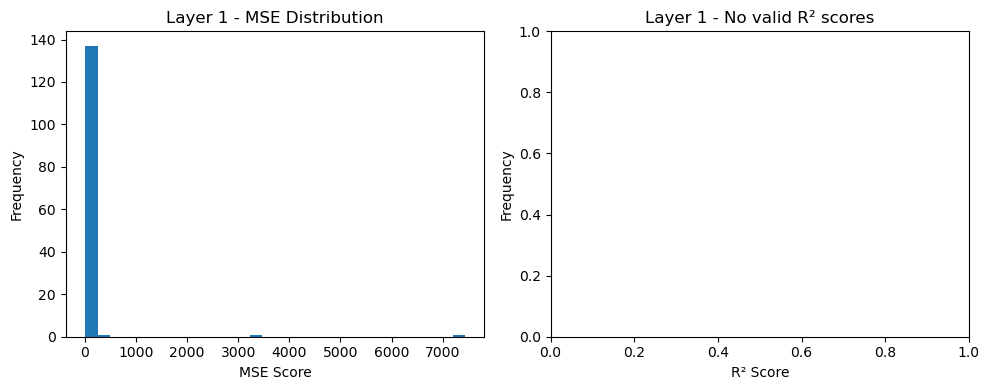

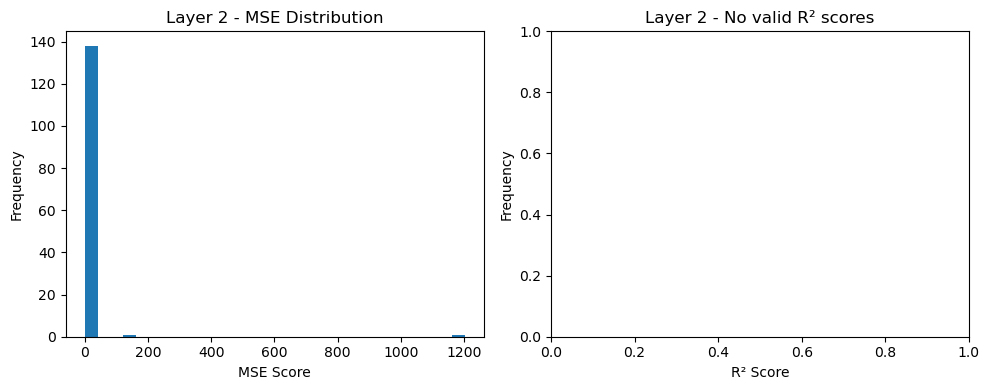

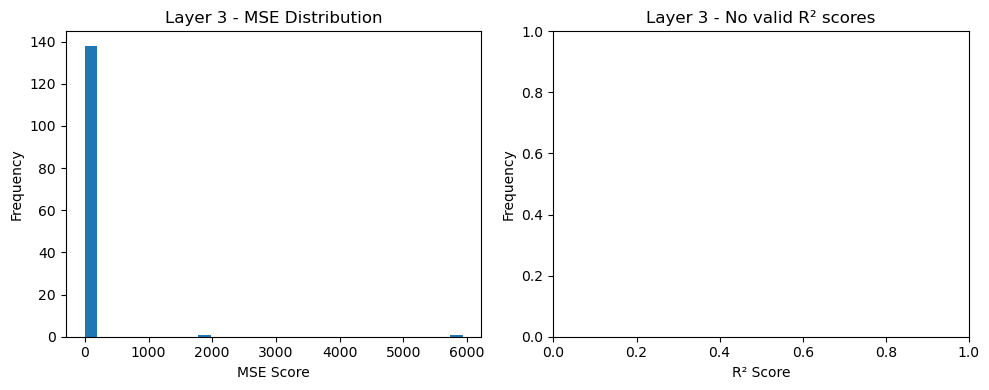

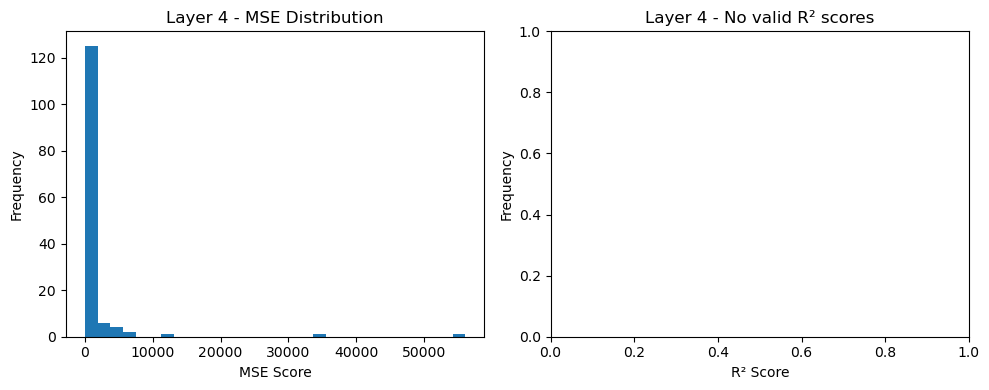

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

def train_probe_for_node(features, property_value, num_epochs=100, learning_rate=0.01):
    # Convert features to PyTorch tensor if it's a NumPy array
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)

    # Ensure it's 2D: (1, feature_size)
    if len(features.shape) == 1:
        features = features.unsqueeze(0)
    
    print(f"Training on features with shape: {features.shape} for property value: {property_value}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (1, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Convert property_value to PyTorch tensor
    property_value = torch.tensor([property_value], dtype=torch.float32).unsqueeze(0)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, property_value)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(features)
        mse = criterion(pred, property_value).item()
        r2 = r2_score(property_value.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

def evaluate_node_probes(train_features, test_features, train_properties, test_properties):
    num_layers = len(train_features)
    results = []

    for layer_idx in range(num_layers):
        layer_train_features = train_features[layer_idx]
        layer_test_features = test_features[layer_idx]
        
        # Iterate over each node for training
        mse_scores, r2_scores = [], []
        for node_idx, node_features in enumerate(layer_train_features):
            node_property = train_properties[node_idx]
            mse, r2 = train_probe_for_node(node_features, node_property['degree'])  # Example for 'degree'
            mse_scores.append(mse)
            r2_scores.append(r2)
        
        results.append({
            'layer': layer_idx,
            'mse_scores': mse_scores,
            'r2_scores': r2_scores
        })
    
    # Plotting the results
    for result in results:
        layer = result['layer']
        plt.figure(figsize=(10, 4))
        
        # Plot MSE Distribution
        plt.subplot(1, 2, 1)
        plt.hist(result['mse_scores'], bins=30)
        plt.title(f'Layer {layer} - MSE Distribution')
        plt.xlabel('MSE Score')
        plt.ylabel('Frequency')

        # Clean up r2_scores by removing NaNs
        clean_r2_scores = [r2 for r2 in result['r2_scores'] if not np.isnan(r2)]

        # Plot R² Score Distribution
        plt.subplot(1, 2, 2)
        if clean_r2_scores:  # Only plot if we have valid R² scores
            plt.hist(clean_r2_scores, bins=30)
            plt.title(f'Layer {layer} - R² Score Distribution')
            plt.xlabel('R² Score')
            plt.ylabel('Frequency')
        else:
            plt.title(f'Layer {layer} - No valid R² scores')
            plt.xlabel('R² Score')
            plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()
# Assuming train_features, test_features, train_properties, test_properties are already defined
# evaluate_node_probes(train_features, test_features, train_properties, test_properties)

# Assuming train_features, test_features, train_properties, test_properties are already defined
evaluate_node_probes(train_features, test_features, train_node_properties, test_node_properties)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

def train_probe_for_all_nodes(train_features, train_properties, test_features, test_properties, num_epochs=100, learning_rate=0.01):
    # Convert to PyTorch tensors if they're NumPy arrays
    if isinstance(train_features, np.ndarray):
        train_features = torch.tensor(train_features, dtype=torch.float32)
    if isinstance(train_properties, np.ndarray):
        train_properties = torch.tensor(train_properties, dtype=torch.float32)
    if isinstance(test_features, np.ndarray):
        test_features = torch.tensor(test_features, dtype=torch.float32)
    if isinstance(test_properties, np.ndarray):
        test_properties = torch.tensor(test_properties, dtype=torch.float32)

    model = LinearModel(train_features.shape[1])  # Input size is the feature dimension
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_properties = train_properties.unsqueeze(1)  # Ensure it's 2D: (num_nodes, 1)
    test_properties = test_properties.unsqueeze(1)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_features)
        loss = criterion(outputs, train_properties)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(test_features)
        mse = criterion(pred, test_properties).item()
        r2 = r2_score(test_properties.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

def evaluate_layers_with_one_classifier(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor):
    num_layers = len(train_features)
    num_properties = train_node_properties_tensor.shape[1]

    test_losses = torch.zeros((num_layers, num_properties))
    r2_scores = torch.zeros((num_layers, num_properties))

    for layer_idx in range(num_layers):
        for prop_idx in range(num_properties):
            train_x = torch.tensor(train_features[layer_idx])  # Shape: (num_train_nodes, 128)
            test_x = torch.tensor(test_features[layer_idx])    # Shape: (num_test_nodes, 128)
            train_y = train_node_properties_tensor[:, prop_idx]  # Shape: (num_train_nodes,)
            test_y = test_node_properties_tensor[:, prop_idx]    # Shape: (num_test_nodes,)

            # Train one classifier on all nodes for the given property
            mse, r2 = train_probe_for_all_nodes(train_x, train_y, test_x, test_y)
            test_losses[layer_idx, prop_idx] = mse
            r2_scores[layer_idx, prop_idx] = r2

    # Plotting the results for MSE loss
    property_names = ['Degree', 'Clustering Coefficient']  # Adjust according to your properties
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), test_losses[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (MSE)")

    plt.xlabel("Layer")
    plt.ylabel("Test Loss (MSE)")
    plt.title("Diagnostic Classifier Performance by Layer (MSE)")
    plt.legend()
    plt.show()

    # Plotting the results for R² score
    for prop_idx in range(num_properties):
        plt.plot(range(num_layers), r2_scores[:, prop_idx].numpy(), label=f"{property_names[prop_idx]} (R²)")

    plt.xlabel("Layer")
    plt.ylabel("R² Score")
    plt.title("Diagnostic Classifier Performance by Layer (R²)")
    plt.legend()
    plt.show()

# Assuming train_features, test_features, train_node_properties_tensor, and test_node_properties_tensor are already defined
evaluate_layers_with_one_classifier(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_25740\2857576376.py", line 91, in <module>
    evaluate_layers_with_one_classifier(train_features, test_features, train_node_properties_tensor, test_node_properties_tensor)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_25740\2857576376.py", line 52, in evaluate_layers_with_one_classifier
    num_properties = train_node_properties_tensor.shape[1]
AttributeError: 'dict' object has no attribute 'shape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultr